In [2]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
import scipy.io as sio
from dataclasses import dataclass
from typing import List, Tuple
import os
from dotenv import load_dotenv
load_dotenv()
import tidy3d as td
from tidy3d import web
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt
import AutomationModule as AM
from scipy.optimize import curve_fit
from natsort import natsorted
import numpy as np
import matplotlib.animation as animation
import xarray as xr
import imageio
import matplotlib

In [ ]:
tidy3dAPI = os.environ["API_TIDY3D_KEY"]

In [ ]:
a = 1
medium = td.Medium(permittivity=11.56)

In [ ]:
file = r"H:\phd stuff\structures\SHU_2D\chi_0.30_N_10000_posics.dat"
data = []
centers = []
slicing= 0.1

with open(file,"r") as f: 
    lines = f.read().splitlines() 
    i=0
    index = 1
    num_samples = int(lines[index].split()[0])

    while num_samples>0 and i < 10:
        try:
            num_samples = int(lines[index].split()[0])
            info = lines[index]
            old_index = index
            index += num_samples+1
            li = (lines[old_index+1:index])
            centers = np.array([list(map(float, item.split())) for item in li])
            data += [{
                "centers":centers,
                "Lx":float(lines[old_index].split()[1]),
                "Ly":float(lines[old_index].split()[2]),
                "points":float(lines[old_index].split()[0]),
            }]
            i+=1
        except:
            num_samples = 0

In [ ]:
lambdas =  a/np.array([0.43,0.45])
project_name = r"chi 0.3 N1000 Sample Infinity Space Like Time Monitor Waist 2"
run_name = ""

runtime = 75
min_steps_per_lambda = 20

for k,item in enumerate(data):
    #Tight pulse 

    if k !=0:
        continue

    structure_1 = AM.loadAndRunStructure(key = tidy3dAPI
                ,direction="z", lambda_range=lambdas,
                box_size= data[k]['Lx']*a,runtime=runtime,min_steps_per_lambda=min_steps_per_lambda,
               scaling=1,shuoff_condtion=1e-20, verbose=True,
               monitors=["flux"],
               freqs=20, 
               source="planewave", 
               width=0.20, ref_only=True
               )
           
    print(structure_1.__str__())

    sim = structure_1.sim



    boundaries= td.BoundarySpec(
            x=td.Boundary(plus=td.Absorber(num_layers=1000),minus=td.Absorber(num_layers=1000)),
            y=td.Boundary(plus=td.Absorber(num_layers=1000),minus=td.Absorber(num_layers=1000)),
            z=td.Boundary.periodic(),
        )
    sim = sim.copy(update={'boundary_spec':boundaries})
    sim = sim.copy(update={'sources':[]})
    sim = sim.copy(update={'monitors':[]})


    Lx, Ly = data[k]['Lx']+4,data[k]['Ly']*slicing+20
    sim = sim.copy(update={'size':[Lx,Ly,0]})

    # source = td.PlaneWave(
    #         source_time = td.GaussianPulse(
    #             freq0=structure_1.freq0,
    #             fwidth=structure_1.freqw
    #         ),
    #         size= (4,0,td.inf),
    #         center=(0,-(Lx)*slicing/2-1,0),
    #         direction='+',
    #         pol_angle=np.pi/2,
    #         name='planewave',
    #         )


    source = td.GaussianBeam(
            source_time = td.GaussianPulse(
                freq0=structure_1.freq0,
                fwidth=structure_1.freqw
            ),
            size= (td.inf,0,td.inf),
            center=(0,-(Lx)*slicing/2-1,0),
            direction='+',
            waist_radius=2,
            pol_angle=np.pi/2,
            name='planewave',
            )

    
    ax1 = source.source_time.plot(times=np.linspace(0,structure_1.t_stop, 10000))

    # Extract the data from the Axes object
    line = ax1.get_lines()[0]
    times = line.get_xdata()
    amplitude = line.get_ydata()

    fig, ax = plt.subplots(figsize=(15, 10))
    ax.plot(times*1e12, amplitude)
    ax.set_xlabel(r"t[ps]")
    ax.set_ylabel('Amplitude')
    ax.set_title('Source Amplitude')
    ax.legend(['Source Spectrum'])
    plt.xlim(0,1)
    #plt.savefig(f'{store_path}/source_time.pdf', format='pdf')
    plt.show()
    
    ax2=source.source_time.plot_spectrum(times=np.linspace(0, structure_1.t_stop, 10000))
     #Extract the data from the Axes object
    c = td.C_0 
    line = ax2.get_lines()[0]
    freqs = line.get_xdata()
    amplitude = line.get_ydata()

    # Convert frequency to wavelength (in meters)
    wavelengths = c / freqs

    fig, ax = plt.subplots(figsize=(15, 10))
    ax.plot(a/wavelengths, amplitude)
    ax.set_xlabel(r"$\nu$'")
    ax.set_ylabel('Amplitude')
    ax.set_title('Source Spectrum')
    ax.legend(['Source Spectrum'])
    #plt.savefig(f'{store_path}/source_freqs.pdf', format='pdf')
    plt.show()
    
    sim = sim.copy(update={'sources':[source]})

    time_monitorFieldOut = td.FieldTimeMonitor(
                center = (0,0,0),
                size = (td.inf,Ly,0),
                    start=0,
                    stop=structure_1.t_stop,
                    interval=int(sim.num_time_steps/40),
                    fields=["Ex", "Ey", "Ez"],
                    name="time_monitorFieldOut",
                    
                )
    

    freq_monitorFieldOut = td.FieldMonitor(
                center = (0,0,0),
                size = (td.inf, Ly,0),
                   freqs =structure_1.monitor_freqs,
                    fields=["Ex", "Ey", "Ez"],
                    name="freq_monitorFieldOut",
                    
                )

    
    time_monitorT = td.FluxTimeMonitor(
                    center = (
                            0,(Lx*slicing)/2+3,0
                            ),
                size = (
                   td.inf,0,td.inf
                    ),
                    interval = 200,
                    name="time_monitorT",

                )
    
    sim = sim.copy(update={'monitors':[time_monitorFieldOut,time_monitorT,freq_monitorFieldOut]})
    
    slab_1 = td.Structure(
                    geometry=td.Box(
                        center= (0,(Ly/2+Lx*slicing/2)/2,0),
                        size=(td.inf,(Ly/2-Lx*slicing/2),td.inf),
                    ),
                    
                    medium=medium,
                    name='slab1',
                    )

    slab_2 = td.Structure(
                    geometry=td.Box(
                        center= (0,-(Ly/2+Lx*slicing/2)/2,0),
                        size=(td.inf,(Ly/2-Lx*slicing/2),td.inf),
                    ),
                    medium=medium,
                    name='slab2',
                    )
    
    cyl_group = []
    for x,y in data[k]['centers']:
        if np.abs(y)<=(Lx/2)*slicing:
            cyl_group.append(td.Cylinder(center=[x, y, 0], radius=0.189, length=td.inf))

    cylinders = td.Structure(geometry=td.GeometryGroup(geometries=cyl_group), medium=medium)

    sim = sim.copy(update={'structures':[cylinders]})
    fig, ax = plt.subplots(1, tight_layout=True, figsize=(16, 8))
    sim.plot(z=0, ax=ax)
    plt.show()

    sim_name = run_name if run_name else f"pnas_d_t_Localization {1/lambdas[0]:.3g} - {1/lambdas[1]:.3g} - Sample_{k}"
    id =web.upload(sim, folder_name=project_name,task_name=sim_name, verbose=True)
    web.start(task_id = id)
    web.monitor(task_id=id,verbose=True)
    ids = '\n' + id
    incidence_folder = "z_incidence"
    file_path = f"data/{project_name}/{incidence_folder}/{sim_name}.txt"
    # Check if the folder exists
    if not os.path.exists( f"data/{project_name}/{incidence_folder}"):
        os.makedirs(f"data/{project_name}/{incidence_folder}")
        print(f"Folder '{project_name}/{incidence_folder}' created successfully.")

    # Open file in write mode
    with open(file_path, "w") as file:
        # Write the string to the file
        file.write(ids)

    sim_data = web.load(id)


In [3]:
sim_data = web.load("fdve-94b029e7-ac12-4e14-ad6a-89c6c5eeb45f")

Output()

16:19:35 W. Europe Daylight Time loading simulation from simulation_data.hdf5

16:19:37 W. Europe Daylight Time WARNING: Simulation final field decay value of 
                                 4.33e-06 is greater than the simulation shutoff
                                 threshold of 1e-20. Consider running the       
                                 simulation again with a larger 'run_time'      
                                 duration for more accurate results.            

In [25]:
def create_movie(field_time_out, monitor_lambdas,name='',type='t',log=False,path="",frames_per_second=1,rem_frames=False):
    frames = []
    if log:
        field_log = np.log10((field_time_out))
        folder_pics = "logPics"
    else:
        field_log = ((field_time_out))
        folder_pics = "linPics"

    for i, time in enumerate(field_time_out):
        try:
            fig, ax = plt.subplots(figsize=(14, 18))
            if type=="t":
                pcolormesh = (field_log).isel(t=i).squeeze().plot.pcolormesh(ax=ax,cmap="plasma")
            else:
                pcolormesh = (field_log).isel(f=i).squeeze().plot.pcolormesh(ax=ax,cmap="plasma")

            ax.set_aspect('auto', adjustable='box')
            plt.ylim(-50,50)
            try:
                plt.title(f'Time: {str(np.array(field_time_out['t'][()][i])*1e12)} ps')
            except:
                plt.title(f'$a/\lambda$: {(1/np.array(td.C_0/field_time_out['f'][()][i])):.4g}')


            # Save the frame
            plt.savefig(f'{path}/{folder_pics}/frame_{i}.png')
            plt.close(fig)
            frames.append(f'{path}/{folder_pics}/frame_{i}.png')
        except:
            break
        

    name_movie = f'{path}/{name}.mp4' if name else f'output/anderson/d(t) analysis/Diameter d(t) at output of the structure Range - {monitor_lambdas[0]:.3g} - {monitor_lambdas[-1]:.3g}.mp4'
    with imageio.get_writer(name_movie, fps=frames_per_second) as writer:
        for frame in frames:
            image = imageio.imread(frame)
            writer.append_data(image)

    # Optionally, remove the individual frames if no longer needed
    if rem_frames:
        for frame in frames:
            os.remove(frame)
    
    return False

<>:23: SyntaxWarning: invalid escape sequence '\l'
<>:23: SyntaxWarning: invalid escape sequence '\l'
C:\Users\HernandF\AppData\Local\Temp\ipykernel_23776\407139116.py:23: SyntaxWarning: invalid escape sequence '\l'
  plt.title(f'$a/\lambda$: {(1/np.array(td.C_0/field_time_out['f'][()][i])):.4g}')


In [6]:
lambdas =  1/np.array([0.286,0.44])

In [8]:
field_freq_out = sim_data.get_intensity("freq_monitorFieldOut")
field_time_out = sim_data.get_intensity("time_monitorFieldOut")


In [26]:
font = {
        'size'   : 32}

matplotlib.rc('font', **font)
# create_movie(field_time_out,1/lambdas,"output/2D SHU/Test Loc/timemonitor",type="t",log=False)
# create_movie(field_time_out,1/lambdas,"output/2D SHU/Test Loc/timemonitorlog",type="t",log=True)

C:\Users\HernandF\AppData\Local\Temp\ipykernel_23776\407139116.py:37: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  image = imageio.imread(frame)
IMAGEIO FFMPEG_WRITER WARNING: input image is not divisible by macro_block_size=16, resizing from (1400, 1800) to (1408, 1808) to ensure video compatibility with most codecs and players. To prevent resizing, make your input image divisible by the macro_block_size or set the macro_block_size to 1 (risking incompatibility).


False

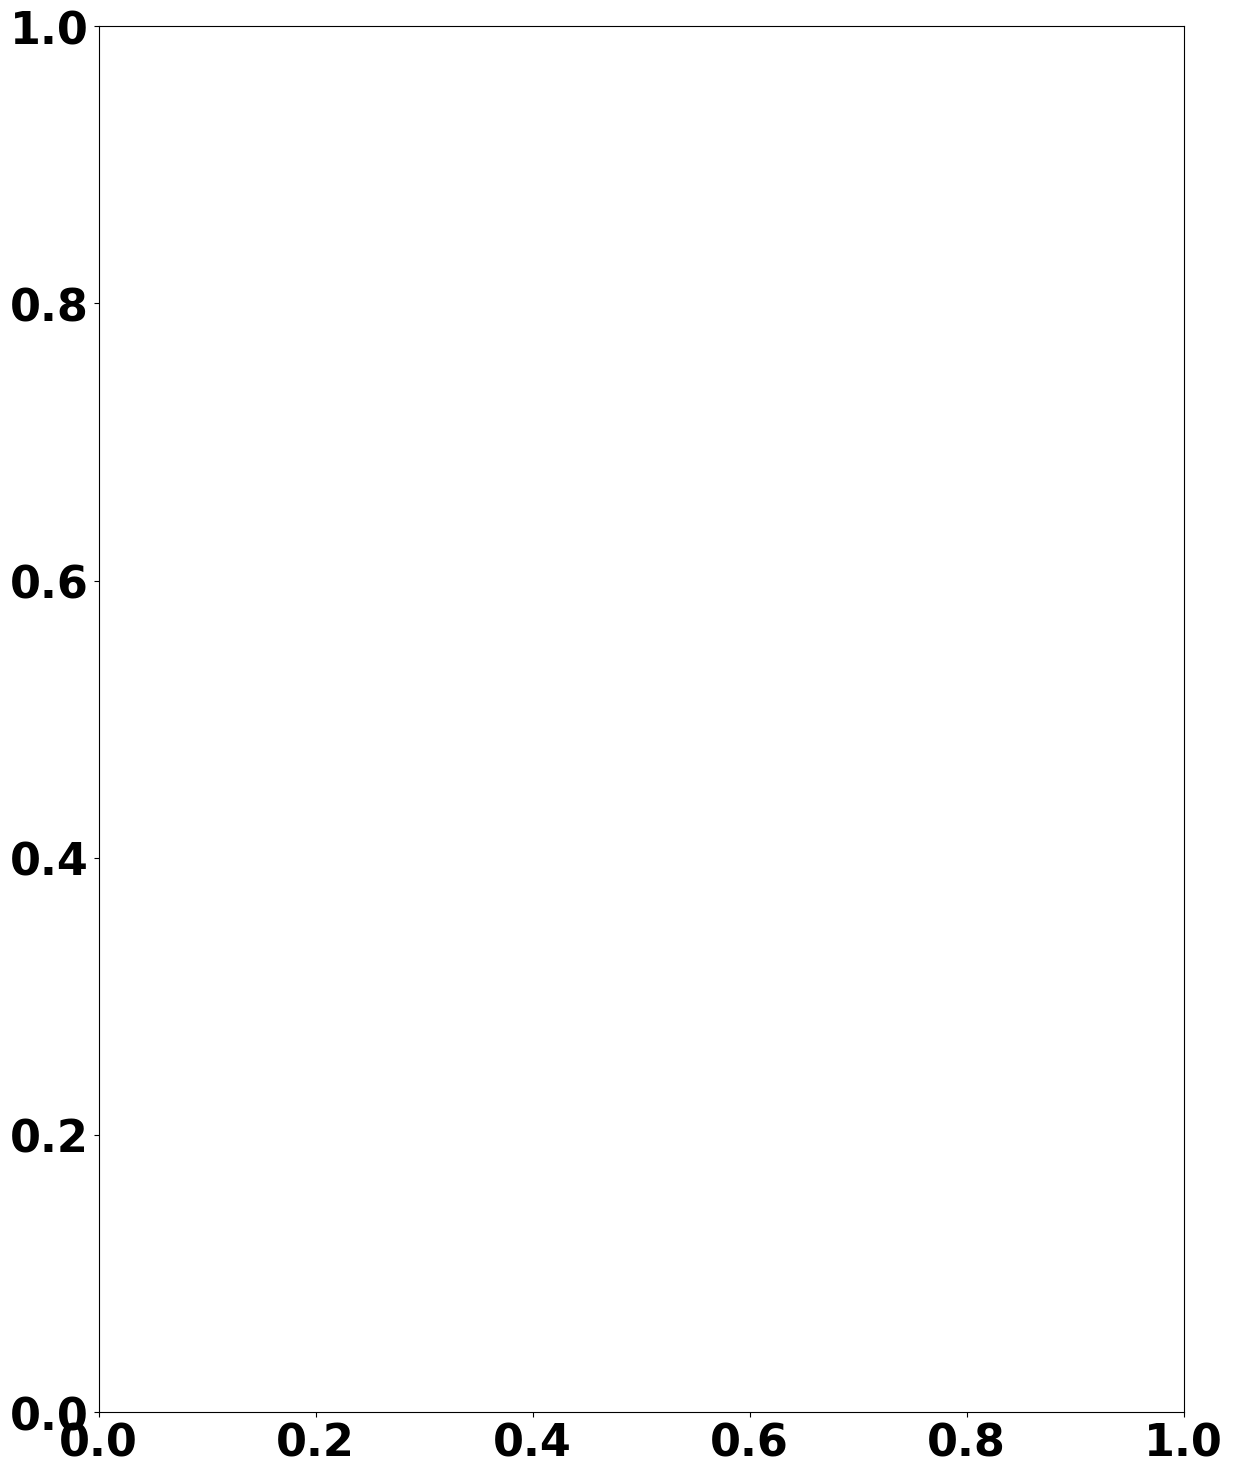

In [27]:
#create_movie(field_freq_out,1/lambdas,f"freqmonitor {1/lambdas[0]:.3g} - {1/lambdas[-1]:.3g}",type="f",log=False,path=f"output/2D SHU/Beam Spreading Chi 0.3 N10000",frames_per_second=1)
create_movie(field_freq_out,1/lambdas,f"freqmonitorlog {1/lambdas[0]:.3g} - {1/lambdas[-1]:.3g}",type="f",log=True,path=f"output/2D SHU/Beam Spreading Chi 0.3 N10000",frames_per_second=1)